Ссылка на датасет: https://www.kaggle.com/datasets/htagholdings/property-sales


Задача: 
Cпрогнозировать цены (или средние цены) на 8 кварталов вперёд 


Столбцы в наборе:
- **Дата продажи**
- **Цена**
- **Тип недвижимости**: квартира или дом
- **Количество спален**: 1, 2, 3, 4, 5 
- **4-значный почтовый индекс** 

In [19]:
!nvidia-smi

Thu Jun  5 15:28:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.51.02              Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        On  |   00000000:0A:00.0  On |                  N/A |
|  0%   51C    P8            N/A  /  130W |    6448MiB /   8188MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
import matplotlib.dates as mdates
import numpy as np

2025-06-11 07:19:18.289942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749615558.435334     997 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749615558.474455     997 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749615558.772411     997 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749615558.772449     997 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749615558.772451     997 computation_placer.cc:177] computation placer alr

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pandas as pd
df = pd.read_csv("house_sales.csv", parse_dates=["datesold"])

In [4]:
df.isnull().sum()

datesold        0
postcode        0
price           0
propertyType    0
bedrooms        0
dtype: int64

In [5]:
print(df.head())

    datesold  postcode   price propertyType  bedrooms
0 2007-02-07      2607  525000        house         4
1 2007-02-27      2906  290000        house         3
2 2007-03-07      2905  328000        house         3
3 2007-03-09      2905  380000        house         4
4 2007-03-21      2906  310000        house         3


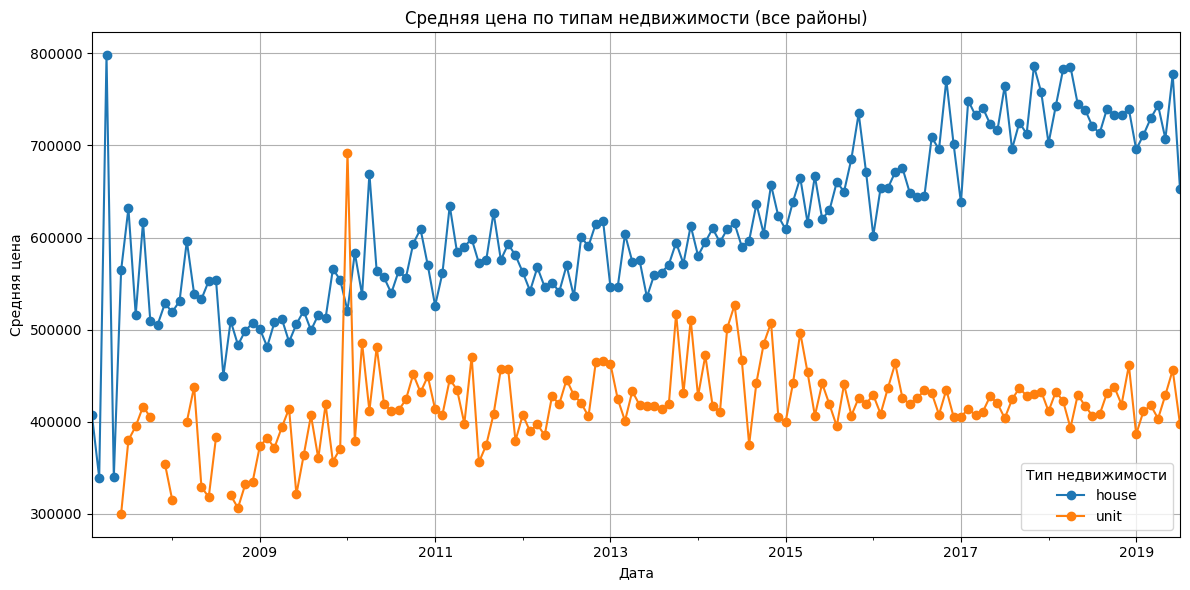

In [ ]:
import matplotlib.pyplot as plt

# Установим дату как индекс
df_time = df.set_index('datesold')

# Группировка по месяцу и типу недвижимости
monthly_avg_by_type = df_time.groupby([pd.Grouper(freq='ME'), 'propertyType'])['price'].mean().unstack()


plt.figure(figsize=(12,6))
monthly_avg_by_type.plot(ax=plt.gca(), marker='o')

plt.title('Средняя цена по типам недвижимости (все районы)')
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.grid(True)
plt.legend(title='Тип недвижимости')
plt.tight_layout()
plt.show()


In [32]:
# Группировка и агрегация по кварталам
df_q = df.groupby([
    pd.Grouper(key='datesold', freq='QE'),
    'propertyType',
    'bedrooms'
])['price'].mean().reset_index()

In [33]:
n_steps = 5
forecast_steps = 8

In [34]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)


In [35]:
group = df_q[(df_q['propertyType'] == 'unit') & (df_q['bedrooms'] == 2)]
series = group.set_index('datesold')['price'].dropna()

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1, 1))

X, y = create_sequences(scaled, n_steps)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [37]:
# Добавляем размерность для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [38]:
model = Sequential([
    Input(shape=(n_steps, 1)),
    LSTM(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=0)

I0000 00:00:1749616951.675728     997 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:0a:00.0, compute capability: 8.9
I0000 00:00:1749616954.573368    2793 service.cc:152] XLA service 0x7ec2dc003a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749616954.573420    2793 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-06-11 07:42:34.625916: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749616954.901683    2793 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-11 07:45:31.686338: E external/local_xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module a_inference_one_step_on_data_2039__.1413] Very slow compi

In [39]:
from keras.layers import SimpleRNN
model_rnn = Sequential([
    Input(shape=(n_steps, 1)),
    SimpleRNN(64, activation='relu'),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train, y_train, epochs=50, verbose=0)

In [40]:
last_window = scaled[-n_steps:]
forecast_rnn = []
input_seq = last_window
for _ in range(forecast_steps):
    pred = model_rnn.predict(input_seq.reshape(1, n_steps, 1), verbose=0)
    forecast_rnn.append(pred[0, 0])
    input_seq = np.append(input_seq[1:], pred)[-n_steps:]
forecast_rescaled_rnn = scaler.inverse_transform(np.array(forecast_rnn).reshape(-1,1)).flatten()

In [41]:
last_window = scaled[-n_steps:]
forecast = []
input_seq = last_window

for _ in range(forecast_steps):
    pred = model.predict(input_seq.reshape(1, n_steps, 1), verbose=0)
    forecast.append(pred[0, 0])
    input_seq = np.append(input_seq[1:], pred)[-n_steps:]

forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

LSTM MAE: 10004.39
LSTM MSE: 138791613.01
LSTM RMSE: 11780.99
LSTM MAPE: 2.33%


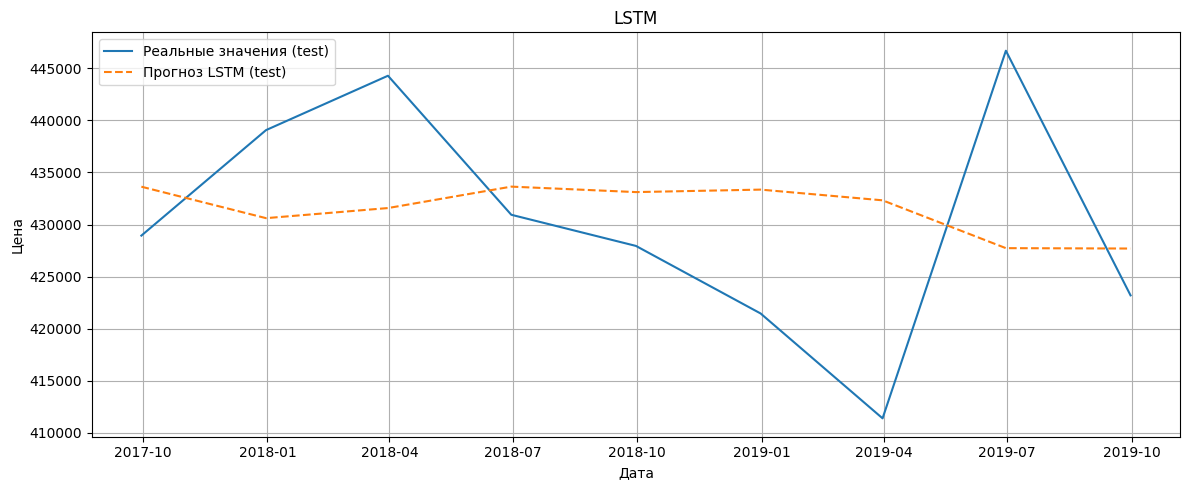

In [44]:
# Прогноз LSTM на X_test
y_pred_lstm = model.predict(X_test, verbose=0)
y_pred_lstm_rescaled = scaler.inverse_transform(y_pred_lstm)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Метрики LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm_rescaled)
mse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm_rescaled)
rmse_lstm = mse_lstm ** 0.5
mape_lstm = (abs((y_test_rescaled.flatten() - y_pred_lstm_rescaled.flatten()) / y_test_rescaled.flatten()).mean()) * 100

# Вывод метрик
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM MSE: {mse_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAPE: {mape_lstm:.2f}%")

# График
plt.figure(figsize=(12,5))
plt.plot(series.index[-len(y_test_rescaled):], y_test_rescaled, label='Реальные значения (test)')
plt.plot(series.index[-len(y_test_rescaled):], y_pred_lstm_rescaled, '--', label='Прогноз LSTM (test)')
plt.title("LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RNN MAE: 10982.49
RNN MSE: 161999808.03
RNN RMSE: 12727.91
RNN MAPE: 2.55%


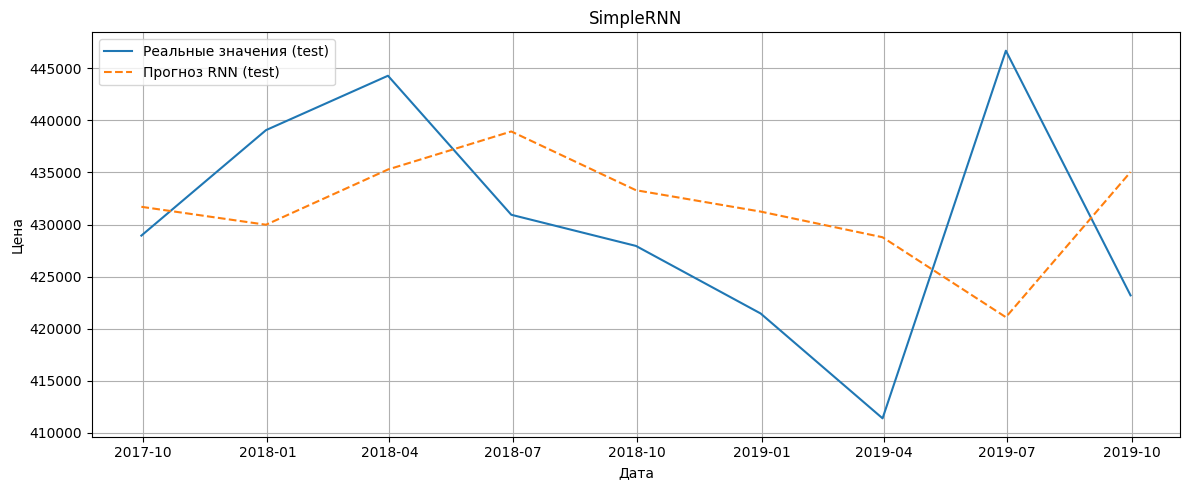

In [46]:
# Прогноз RNN на X_test
y_pred_rnn = model_rnn.predict(X_test, verbose=0)
y_pred_rnn_rescaled = scaler.inverse_transform(y_pred_rnn)

# Метрики RNN
mae_rnn = mean_absolute_error(y_test_rescaled, y_pred_rnn_rescaled)
mse_rnn = mean_squared_error(y_test_rescaled, y_pred_rnn_rescaled)
rmse_rnn = mse_rnn ** 0.5
mape_rnn = (abs((y_test_rescaled.flatten() - y_pred_rnn_rescaled.flatten()) / y_test_rescaled.flatten()).mean()) * 100

# Вывод метрик
print(f"RNN MAE: {mae_rnn:.2f}")
print(f"RNN MSE: {mse_rnn:.2f}")
print(f"RNN RMSE: {rmse_rnn:.2f}")
print(f"RNN MAPE: {mape_rnn:.2f}%")

# График
plt.figure(figsize=(12,5))
plt.plot(series.index[-len(y_test_rescaled):], y_test_rescaled, label='Реальные значения (test)')
plt.plot(series.index[-len(y_test_rescaled):], y_pred_rnn_rescaled, '--', label='Прогноз RNN (test)')
plt.title("SimpleRNN")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Группа: unit, 2 спальни
group = df_q[(df_q['propertyType'] == 'unit') & (df_q['bedrooms'] == 2)]

series = group.set_index('datesold')['price'].asfreq('QE').fillna(method='ffill')

/tmp/ipykernel_997/2930795241.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = group.set_index('datesold')['price'].asfreq('QE').fillna(method='ffill')


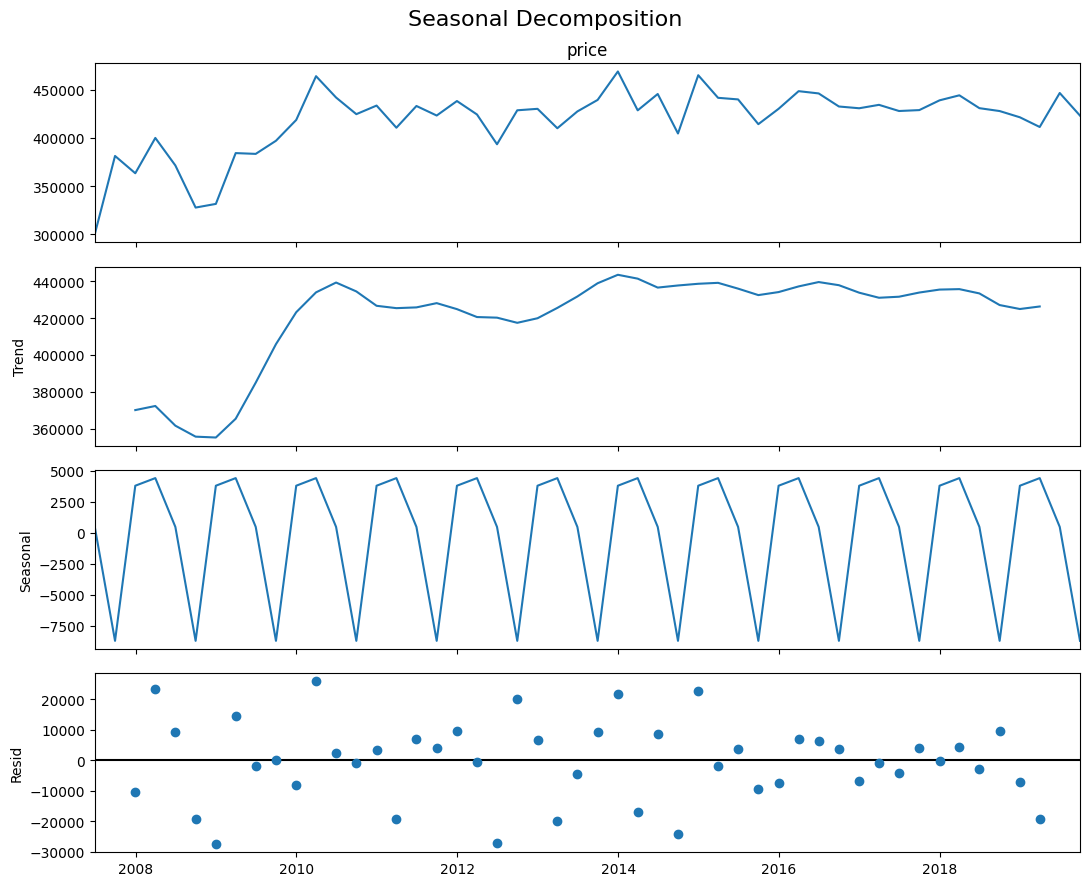

ADF Statistic: -4.533813
p-value: 0.000171
Critical Values:
   1%, -3.5714715250448363
Critical Values:
   5%, -2.922629480573571
Critical Values:
   10%, -2.5993358475635153
Временной ряд стационарен (отвергаем нулевую гипотезу)


In [ ]:
# Разложение временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

# Выполняем разложение
decompose = seasonal_decompose(series, model='additive')  
decompose.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

# Тест Дикки-Фуллера
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series.dropna())

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
for key, value in adf_result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')
    
if adf_result[1] < 0.05:
    print("Временной ряд стационарен (отвергаем нулевую гипотезу)")
else:
    print("Временной ряд не стационарен (не отвергаем нулевую гипотезу)")


In [ ]:
# Разделение на train / test для оценки прогноза
test_size = forecast_steps  
train = series[:-test_size]
test = series[-test_size:]


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA модель на train
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,4))
sarima_fit = sarima_model.fit(disp=False)

# Прогноз SARIMA на длину test
forecast_sarima = sarima_fit.get_forecast(steps=test_size)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_index = test.index

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae_sarima = mean_absolute_error(test, forecast_sarima_mean)
mse_sarima = mean_squared_error(test, forecast_sarima_mean)
rmse_sarima = mse_sarima ** 0.5
mape_sarima = (abs((test - forecast_sarima_mean) / test).mean()) * 100


print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA MSE: {mse_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAPE: {mape_sarima:.2f}%")

SARIMA MAE: 19880.69
SARIMA MSE: 570811336.61
SARIMA RMSE: 23891.66
SARIMA MAPE: 4.69%


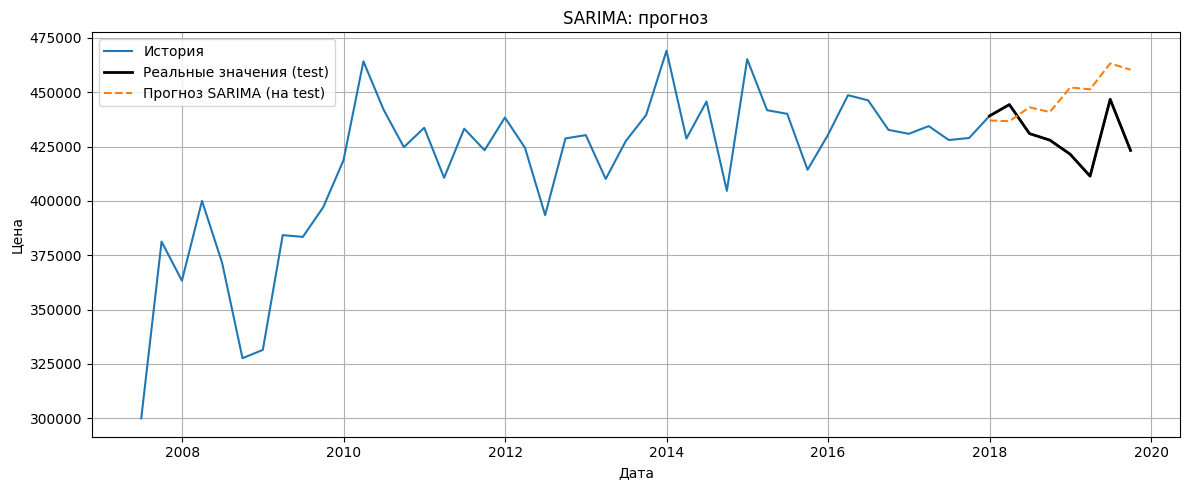

In [30]:
plt.figure(figsize=(12,5))
plt.plot(series, label='История')
plt.plot(test.index, test.values, label='Реальные значения (test)', color='black', linewidth=2)
plt.plot(forecast_index, forecast_sarima_mean, '--', label='Прогноз SARIMA (на test)')
plt.title("SARIMA: прогноз")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA модель на train
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

# Прогноз ARIMA на длину test
forecast_arima = arima_fit.get_forecast(steps=test_size).predicted_mean
forecast_index = test.index

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


mae = mean_absolute_error(test, forecast_arima)
mse = mean_squared_error(test, forecast_arima)
rmse = mse ** 0.5
mape = (abs((test - forecast_arima) / test).mean()) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 9621.43
MSE: 130943793.89
RMSE: 11443.07
MAPE: 2.23%


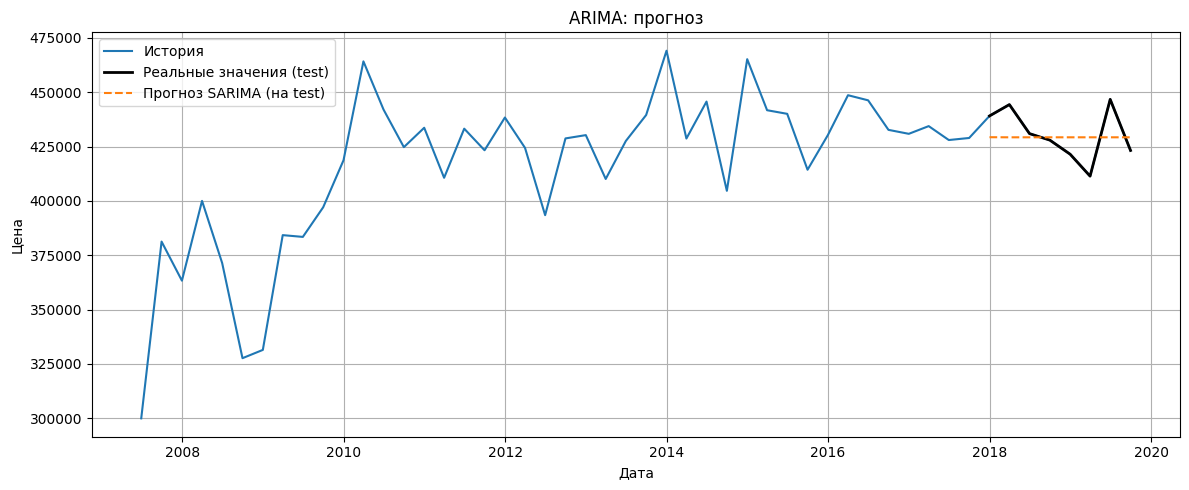

In [31]:
plt.figure(figsize=(12,5))
plt.plot(series, label='История')
plt.plot(test.index, test.values, label='Реальные значения (test)', color='black', linewidth=2)
plt.plot(forecast_index, forecast_arima, '--', label='Прогноз SARIMA (на test)')
plt.title("ARIMA: прогноз")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
